In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import scipy as sc
from scipy import ndimage
from skimage import filters
from matplotlib import pyplot as plt
from PIL import Image

import plotly.express as px

# sns.set(context='poster')
%matplotlib inline

<IPython.core.display.Javascript object>

### Problem 1

(600, 800, 3)



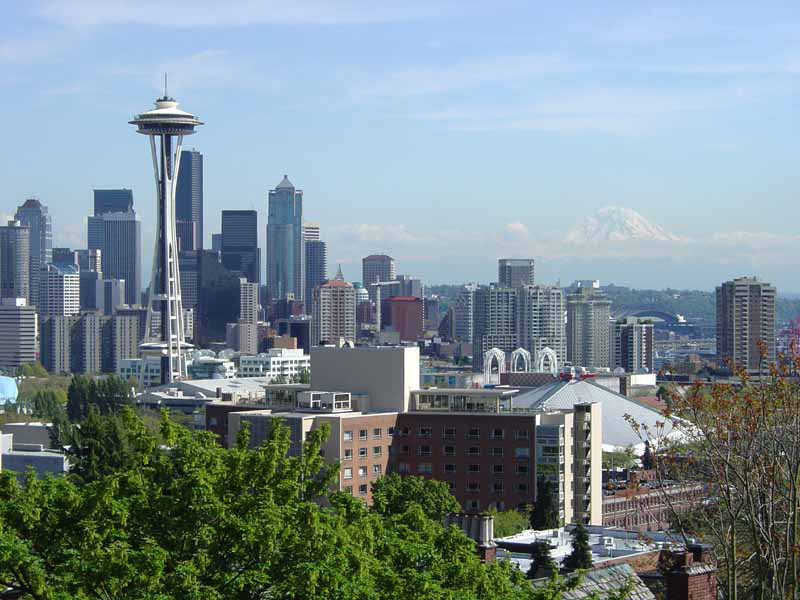

<IPython.core.display.Javascript object>

In [340]:
image = Image.open("hw1_data/Seattle.jpg")  # .convert("L")
image = np.asarray(image)
print(image.shape)
px.imshow(image, color_continuous_scale="gray")

Gaussian filter is defined as: $$ G(\mathbf{x}; \sigma^2) = \frac{1}{2 \pi \sigma^2} \exp{-\frac{\mathbf{x}^T \mathbf{x}}{2 \sigma^2}}$$

In [364]:
# Trick for colors
# np.stack([np.arange(16).reshape(4,4)])*3, axis = -1).shape

# # First lets write a convolve function
def convolve(image, flter):
    filter_size = flter.shape[0]

    padimage = imagepadding(image, filter_size)
    rowsize = image.shape[0]
    colsize = image.shape[1]

    im_filtered = np.zeros_like(padimage, dtype=np.float32)

    for i in range(rowsize):  # rows
        for j in range(colsize):  # columns
            submat = padimage[i : i + filter_size, j : j + filter_size]
            im_filtered[i, j] = np.sum(np.multiply(submat, flter))
    return im_filtered

# Image Padding function
def imagepadding(image, sizeofpad):
    sizeofpad = sizeofpad // 2
    rowsize = image.shape[0]
    colsize = image.shape[1]

    # Multiply by two since padding is double sided
    padimage = np.zeros(shape=(rowsize + 2 * sizeofpad, colsize + 2 * sizeofpad))

    # Plant the image in the middle of the new matrix, equidistant from the edges
    padimage[sizeofpad:-sizeofpad, sizeofpad:-sizeofpad] = image
    return padimage

<IPython.core.display.Javascript object>

The final resolution is  (600, 800, 3)



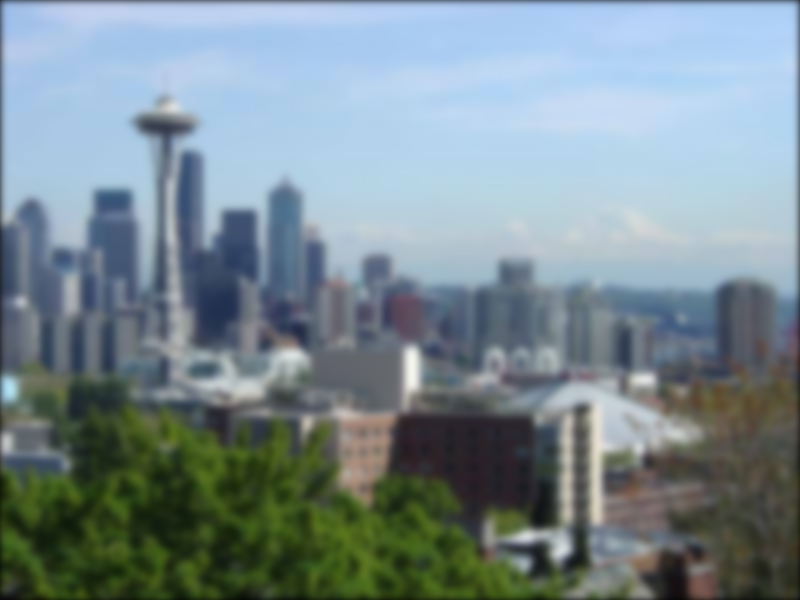

<IPython.core.display.Javascript object>

In [367]:
def GaussianBlurImage(image, sigma):
    # Builds the filter
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
    for i in range(filter_size):
        for j in range(filter_size):
            x = i - filter_size // 2
            y = j - filter_size // 2
            gaussian_filter[i, j] = (
                1
                / (2 * np.pi * sigma ** 2)
                * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
            )

    # Declare blank filter (zeros)
    # Doing this since I can not pad a 3 dimensional picture with the current function
    padimage = np.zeros(shape = (image.shape[0] + gaussian_filter.shape[0] - 1,
        image.shape[1] + gaussian_filter.shape[0] -1, 3))

    im_filtered = np.zeros(shape = (padimage.shape[0], padimage.shape[1], 3), dtype=np.float32)

    #Filter for each RGB
    for c in range(image.shape[2]):
        im_filtered[:, :, c] = convolve(image[:, :, c], gaussian_filter)

    # RGB version
    im_filtered = im_filtered[
        : image.shape[0], 
        : image.shape[1],
        :,
    ]

    print("The final resolution is ", im_filtered.shape)
    fig = px.imshow(np.clip(im_filtered, 0, 255).astype(np.uint8))
    fig.write_image("1.png")
    return fig


GaussianBlurImage(image, 4)

In [368]:
# im_filtered_skimage = filters.gaussian(
#     image, sigma=4, mode="constant", cval=0.0, multichannel=True, preserve_range=True
# )
# print(im_filtered_skimage.shape)
# px.imshow(im_filtered_skimage)

<IPython.core.display.Javascript object>

### Problem 2

In [388]:
### ARTIFACTS MIGHT BE BECAUSE OF LACK OF CONVERION TO UINT8 CHECK DISCUSSION NOTEBOOK
def sepConvolve(image, flter, axis=0, padimage=None):
    filter_size = flter.shape[0]
    if padimage is None:
        padimage = imagepadding(image, filter_size)
    else:
        padimage = padimage

    # padimage = imagepadding(image, filter_size)

    # Zeros
    im_filtered = np.zeros_like(padimage, dtype=np.float32)

    rowsize = image.shape[0]
    colsize = image.shape[1]

    # Conditional for which axis to apply filter on
    if axis == 1:  # column blur
        for i in range(colsize):
            for j in range(rowsize):
                subvec = padimage[j : j + filter_size, i]
                print("im_filtered shape", im_filtered.shape)
                im_filtered[j, i] = np.sum(np.multiply(subvec, flter))
    else:  # row blur
        for i in range(rowsize):
            #print("i is ", i )
            #print("im_filtered shape", im_filtered.shape)
            for j in range(colsize):

                subvec = padimage[i, j : j + filter_size]
                im_filtered[i, j] = np.sum(np.multiply(subvec, flter))
    return im_filtered


def SeparableGaussianBlurImage(image, sigma):
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    # print("Filter size = ", filter_size)
    gaussian_filter = np.zeros((filter_size), np.float32)
    for i in range(filter_size):
        x = i - filter_size // 2

        gaussian_filter[i] = (  # univariate gaussian
            1
            / np.sqrt(2 * np.pi * sigma ** 2)
            * np.exp(
                -(x ** 2) / (2 * sigma ** 2)
            )  # need sqrt in denominator of constant
        )

    #im_filtered = np.zeros_like(image, dtype=np.float32)
    
    padimage = np.zeros(shape = (image.shape[0] + gaussian_filter.shape[0],
        image.shape[1] + gaussian_filter.shape[0], 3))
    im_filtered = np.zeros(shape = (padimage.shape[0] - 1, padimage.shape[1] - 1, 3), dtype=np.float32)
    print("im_filtered shape is ", im_filtered.shape)
    #     im_filtered = sepConvolve(image, gaussian_filter, axis=0)
    #     im_filtered = sepConvolve(im_filtered, gaussian_filter, axis=1, padimage=padimage)

    # Filter for each RGB
    for c in range(3):
        # Image padding
        #padimage = imagepadding(image[:, :, c], filter_size)
        # Row
        im_filtered[:, :, c] = sepConvolve(image[:, :, c], gaussian_filter, axis=0)
        # Column
        im_filtered[:, :, c] = sepConvolve(
            im_filtered[:, :, c], gaussian_filter, axis=1, padimage=padimage[:, :, c]
        )

    fig = px.imshow(np.clip(im_filtered, 0, 255).astype(np.uint8))
    fig.write_image("2.png")

    return fig


SeparableGaussianBlurImage(image, 4.0)

im_filtered shape is  (632, 832, 3)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filtered shape (633, 833)
im_filt

ValueError: operands could not be broadcast together with shapes (32,) (33,) 

<IPython.core.display.Javascript object>

### Problem 3

In [29]:
yosemite = Image.open("hw1_data/Yosemite.png").convert("L")
yosemite = np.asarray(yosemite)
px.imshow(yosemite, color_continuous_scale="gray")

<IPython.core.display.Javascript object>

In [389]:
def SharpenImage(image, sigma, alpha):
    mask = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
#     padimage = imagepadding(image, 1)
    
#     rowsize = image.shape[0]
#     colsize = image.shape[1]
    
#     im_filtered = np.zeros_like(image, dtype=np.float32)
    
#     for i in range(rowsize- 2):
#         #print("i is ", i)
#         for j in range(colsize- 2):
#             #print("BEFORE:", im_filtered[i,j])
#             im_filtered[i, j] = np.sum(np.multiply(mask, im_filtered[i:i+3, j:j+3]))
#             #print("AFTER: ",im_filtered[i,j])

    im_filtered = np.zeros_like(image, dtype=np.float32)
    im_filtered = convolve(image, mask)
    
    sharp = image - alpha * im_filtered
    fig = px.imshow(sharp, color_continuous_scale="gray")
    
    
    return fig

SharpenImage(yosemite, 3, 2)


ValueError: operands could not be broadcast together with shapes (334,500) (336,502) 

<IPython.core.display.Javascript object>